In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

    
from datetime import datetime, date, time
import matplotlib.pyplot as plt

    
    
from photonflow.utils import regularizers
from photonflow.layers.photonic_convolutional import photonic_conv2d, photonic_maxpool2d
from photonflow.layers.photonic_dense import photonic_dense
from photonflow.core.Activation_Functions.AF import modulator_optical_activation, getOptimalLength
from photonflow.core.Activation_Functions.modulatorTFLKeras import modulatorFunctions


#from tensorflow.utils import regularizers
#from tensorflow.contrib.layers.python.layers import regularizers
#from tensorflow.layers import conv2d, maxpool2d
#from tensorflow.layers import dense
#from tensorflow.nn import relu


import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib.framework.python.ops import arg_scope
from tensorflow.contrib.layers.python.layers import layers as layers_lib
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers.python.layers import utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops
from tensorflow import losses

from keras import backend as K


Using TensorFlow backend.


## Create folder and logging file name

In [2]:
now_time = datetime.now()
now_string = str(now_time.year)+'-'+str(now_time.month)+'-'+str(now_time.day)+'-'+str(now_time.hour)+'-'+str(now_time.minute)

log_dir = os.getcwd()+'/log/'
models_dir = os.getcwd()+'/trained_models/'

training_noise_std = 0.000
print(log_dir)
print(models_dir)

/Users/Armin/Projects/photonflow/photonflow/networks/log/
/Users/Armin/Projects/photonflow/photonflow/networks/trained_models/


## Load input data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Set global variables

In [4]:
# Create a truncated normal initializer
trunc_normal = init_ops.glorot_normal_initializer()

## Create Optical Activation Function

In [5]:
modulatorFunctions

[<function photonflow.core.Activation_Functions.modulatorTFLKeras.graphene_aFunc(V, LGr, getC=False)>,
 <function photonflow.core.Activation_Functions.modulatorTFLKeras.quantum_dot_aFunc(V, LQD, getC=False)>,
 <function photonflow.core.Activation_Functions.modulatorTFLKeras.quantum_well_aFunc(V, LQW, getC=False)>,
 <function photonflow.core.Activation_Functions.modulatorTFLKeras.m3QW_aFunc(V, L3QW, getC=False)>,
 <function photonflow.core.Activation_Functions.modulatorTFLKeras.ex_aFunc(V, LEx, getC=False)>]

In [6]:
laser_power = 1.0e-2  #laser_optical_power = np.linspace(1e-9,50e-3,500)
mod_length = 200      #np.linspace(0.01,500,500)
modfunc = modulatorFunctions[3]
test_plot = lambda x: modulator_optical_activation(x, modfunc, mod_length , laser_power)
x = np.arange(-1, 1, 0.1)
x_ = tf.placeholder(tf.float32, shape=None)
y = test_plot(x_)


In [7]:
with tf.Session() as sess_plot:
    output_array = y.eval(feed_dict={x_:x})
    

/Users/Armin/anaconda3/envs/photonflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


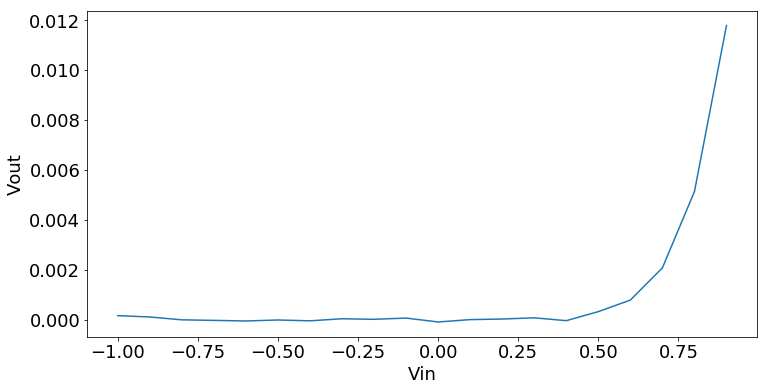

In [8]:
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 18}

plt.rc('font', **font)

f, ax = plt.subplots(figsize=(12, 6))

ax.plot(x,output_array)
ax.set_xlabel('Vin')
ax.set_ylabel('Vout')

plt.show()

In [9]:
# for modfunc in modulatorFunctions:
#         modulator_optical_activations[modfunc] = modulator_optical_activation

#             length = getOptimalLength(modfunc,laser_optical_power)
#         lengths[modfunc] = length
#         print('length ' + str(length))
#         ##### UPDATE KERAS ACTIVATION FUNCTIONS WITH THIS GUY
#         get_custom_objects().update({'modulator_optical_activation': Activation(modulator_optical_activation)})

In [10]:
optical_af = lambda x: modulator_optical_activation(x, modfunc,2.0e-3 , 1.0e-15)

## Define your model

In [11]:
def AlexNet(inputs,
                num_classes=10,
                is_training=True,
                dropout_keep_prob=0.5,
                spatial_squeeze=True,
                scope='ALEXNET'):
    
    
    with tf.variable_scope(scope, [inputs]) as sc:
        end_points_collection = sc.original_name_scope + '_end_points'
    # Collect outputs for conv2d, fully_connected and max_pool2d.
    
        with tf.name_scope('Power_Monitor'):
            power_monitor = tf.Variable(0.0, name='Power_Monitor', trainable=False)
            
        with arg_scope(
            [layers.conv2d, layers_lib.fully_connected, layers_lib.max_pool2d],
            outputs_collections=[end_points_collection]):
            
            output_conv_1, power_monitor, _ = photonic_conv2d(inputs, 16, 3, 1, training_noise_std, 'CONV1', power_monitor)
            #dummy_noise_var = tf.Variable(initial_value=0.0,name='dummy_noise_variable')
            #dummy_noise_var = output_conv_1
            output_maxpool_1, power_monitor = photonic_maxpool2d(output_conv_1, 3, 1, 'MAXPOOL1', power_monitor)
            output_conv_2, power_monitor, test_noise = photonic_conv2d(output_maxpool_1, 64, 1, 1,training_noise_std, 'CONV2', power_monitor)
            output_maxpool_2, power_monitor = photonic_maxpool2d(output_conv_2, 3, 2, 'MAXPOOL2', power_monitor)
            output_conv_3, power_monitor, _ = photonic_conv2d(output_maxpool_2, 64, 1, 1, training_noise_std, 'CONV3', power_monitor)
            output_conv_4, power_monitor, test_noise = photonic_conv2d(output_conv_3, 64, 1, 1, training_noise_std, 'CONV4', power_monitor)
            output_conv_5, power_monitor,_ = photonic_conv2d(output_conv_4, 64, 1, 1, training_noise_std, 'CONV5', power_monitor)
            output_maxpool_5, power_monitor = photonic_maxpool2d(output_conv_5, 3, 2, 'MAXPOOL5', power_monitor)
            
        # Use conv2d instead of fully_connected layers.
        with arg_scope(
            [layers.conv2d, layers_lib.fully_connected],
            weights_initializer=trunc_normal,
            biases_initializer=init_ops.constant_initializer(0.1)):

            weights_initializer=init_ops.constant_initializer(0.1)
            output_dense_6, power_monitor = photonic_dense(output_maxpool_5, 32, dropout_keep_prob, is_training, tf.nn.tanh, None, None, None, weights_initializer,'FC6', power_monitor)
            #tf.summary.histogram('after_activation', output_dense_6)
            output_dense_7, power_monitor = photonic_dense(output_dense_6, 32, dropout_keep_prob, is_training, None, None, None, weights_initializer,'FC7', power_monitor)
            output_dense_8, power_monitor = photonic_dense(output_dense_7, num_classes, dropout_keep_prob, is_training, None, None, weights_initializer,'FC8', power_monitor)



        with tf.name_scope('Output'):
            end_points = utils.convert_collection_to_dict(end_points_collection)
            if spatial_squeeze:
                net = tf.reduce_mean(output_dense_8, [1, 2], keep_dims=True, name='global_pool')
                net = array_ops.squeeze(net, [1, 2], name='fc8/squeezed')
                end_points[sc.name + '/fc8'] = net
                
                
    return net, end_points, power_monitor, test_noise

## Create placeholders and instanstiate the model

In [12]:
x = tf.placeholder(tf.float32, [None, 28,28, 1], name='x_placeholder')
y_ = tf.placeholder(tf.float32, [None, 10], name='y_placeholder')

In [13]:
y, model, power, test_noise = AlexNet(x, num_classes=10)

NOISE STD: Tensor("ALEXNET/CONV1/Noise/Mul_7:0", shape=(), dtype=float32)
SIGNAL RANGE: Tensor("ALEXNET/CONV1/Noise/sub:0", shape=(), dtype=float32)
1/SNR is: Tensor("ALEXNET/CONV1/Noise/truediv_1:0", shape=(), dtype=float32)
NOISE STD: Tensor("ALEXNET/CONV2/Noise/Mul_7:0", shape=(), dtype=float32)
SIGNAL RANGE: Tensor("ALEXNET/CONV2/Noise/sub:0", shape=(), dtype=float32)
1/SNR is: Tensor("ALEXNET/CONV2/Noise/truediv_1:0", shape=(), dtype=float32)
NOISE STD: Tensor("ALEXNET/CONV3/Noise/Mul_7:0", shape=(), dtype=float32)
SIGNAL RANGE: Tensor("ALEXNET/CONV3/Noise/sub:0", shape=(), dtype=float32)
1/SNR is: Tensor("ALEXNET/CONV3/Noise/truediv_1:0", shape=(), dtype=float32)
NOISE STD: Tensor("ALEXNET/CONV4/Noise/Mul_7:0", shape=(), dtype=float32)
SIGNAL RANGE: Tensor("ALEXNET/CONV4/Noise/sub:0", shape=(), dtype=float32)
1/SNR is: Tensor("ALEXNET/CONV4/Noise/truediv_1:0", shape=(), dtype=float32)
NOISE STD: Tensor("ALEXNET/CONV5/Noise/Mul_7:0", shape=(), dtype=float32)
SIGNAL RANGE: Tensor("

TypeError: Expected float32, got <tensorflow.python.ops.init_ops.Constant object at 0xb428229b0> of type 'Constant' instead.

## Total power accumulator

In [ ]:
with tf.name_scope('Overall_Power'):
            unreduced_overall_power = power
            overall_power = tf.reduce_sum(unreduced_overall_power)
            
            tf.summary.scalar('power', overall_power)

## Create training parameters and their summary writers

In [ ]:
with tf.name_scope('Training'):
    # Define loss and optimizer
    cross_entropy = losses.softmax_cross_entropy(onehot_labels=y_, logits=y)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('cross_entropy', cross_entropy)
    init = tf.global_variables_initializer()


## Create batches and start training

In [ ]:
var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='ALEXNET')
saver = tf.train.Saver(var_list, max_to_keep=1)

with tf.Session() as sess:
    sess.run(init)
    latest_checkpoint = tf.train.latest_checkpoint('./trained_models/',latest_filename=None)
    saver.restore(sess, latest_checkpoint)

    train_writer = tf.summary.FileWriter(log_dir+now_string, sess.graph)
    

    
    # Create a writer for the summary data.
    #summary_writer = tf.summary.FileWriter(log_dir+now_string, sess.graph)
    for i in range(100):
        
        total_power = 0.0
        batch_temp = mnist.train.next_batch(32)
        batch = (np.reshape(batch_temp[0],[-1,28,28,1]), batch_temp[1])
        if i%100 == 0:
            
            
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
            
            print("step %d, training accuracy %g"%(i, train_accuracy))

            merged = tf.summary.merge_all()
            
            
            test_noise_eval = sess.run([test_noise],feed_dict={x: batch[0], y_: batch[1]})
            print("SNR VALUE IS:", test_noise_eval)

        
        summary, _ = sess.run([merged, train_step],
                              feed_dict={x: batch[0], y_: batch[1]})

        train_writer.add_summary(summary, i)
    
        
        
    saver.save(sess, './trained_models/model_train_noise_001_all_'+now_string, global_step=i, write_meta_graph=True)
        #test_writer = tf.summary.FileWriter(log_dir+now_string)
        #tf.global_variables_initializer().run()



In [ ]:
with tf.Session() as sess:
    sess.run(init)
    latest_checkpoint = tf.train.latest_checkpoint('./trained_models/',latest_filename=None)
    saver.restore(sess, latest_checkpoint)

    for i in range(1):


            batch_temp = mnist.test.next_batch(10000)
            batch = (np.reshape(batch_temp[0],[-1,28,28,1]), batch_temp[1])            

            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})

            print("Accuracy %g"%(train_accuracy))



In [ ]:
tf.initializers.glorot_normal()